In [1]:
import torch
import torch.nn as nn

# LLM tarining function由一下三步组成
1.文本生成 text generation
2.文本评估 text evaluation 
3.评估模型 training & validation losses

In [3]:
#封装归一化层
# Listing 4.2 A layer normalization class
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
#esp是一个小常数 防止出现除以0的错误
#unbiased 这个参数设置是为了防止样本过少导致归一化过小，
#当设置为true时方差为n-1个样本的，而设置为false的时候就为n个样本
#LLM的样本数量较大所以不需要设置贝塞尔校正
# 激活层 GELU函数 与 RELU相似
# Listing 4.3 An implementation of the GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))
# FeedForward网络模块 
# Listing 4.4 A feed forward neural network module
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)
#上面的MultiHeadAttention是将并行的结果进行拼接，而接下来
# 的这种是将结果进行乘积也就是将张量结果组合在一起
# Listing 3.5 An efficient multi-head attention class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads                        #A
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)                   #B
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            'mask',
             torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )


    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)                                      #C
        queries = self.W_query(x)                                 #C
        values = self.W_value(x)                                  #C

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)       #D
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)   #D
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim) #D

        keys = keys.transpose(1, 2)                               #E
        queries = queries.transpose(1, 2)                         #E
        values = values.transpose(1, 2)                           #E

        attn_scores = queries @ keys.transpose(2, 3)              #F
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]    #G

        attn_scores.masked_fill_(mask_bool, -torch.inf)           #H

        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)     #I

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)  #J
        context_vec = self.out_proj(context_vec)                  #K
        return context_vec


#A 将投影维度缩小，以匹配期望的输出维度
#B 使用线性层组合头部输出
#C 张量形状：(b, num_tokens, d_out)
#D 我们通过添加 num_heads 维度来隐式地拆分矩阵。然后展开最后一个维度，使其形状从 (b, num_tokens, d_out) 转换为 (b, num_tokens, num_heads, head_dim)
#E 将张量的形状从 (b, num_tokens, num_heads, head_dim) 转置为 (b, num_heads, num_tokens, head_dim)
#F 对每个注意力头进行点积运算
#G 掩码被截断到 token 的数量
#H 使用掩码填充注意力分数
#I 张量形状：（b, num_tokens, n_heads, head_dim）
#J 将多个注意力头的输出结果合并，其中输出维度 self.d_out 等于注意力头数 self.num_heads 与每个头的维度 self.head_dim 的乘积
#K 添加一个可选的线性投影层
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x                                          #A
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back
        shortcut = x                                          #B
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut                                       #C
        return x


#A 注意力模块中的快捷连接
#B 前馈网络模块中的快捷链接
#C 将原始输入加回到输出中
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))      #A
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

 #A 设备设置将根据输入数据所在的位置选择在 CPU 或 GPU 上训练模型

In [4]:
# Listing 4.8 A function for the GPT model to generate text
def generate_text_simple(model, idx, max_new_tokens, context_size): #A
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]                           #B
        with torch.no_grad():
           logits = model(idx_cond)

        logits = logits[:, -1, :]                                   #C
        probas = torch.softmax(logits, dim=-1)                      #D
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)       #E
        #其实softmax最大概率值与源向量组最大值的索引是一样实际上softmax是多余的操作
        idx = torch.cat((idx, idx_next), dim=1)                     #F

    return idx


#A idx 是当前上下文中索引的数组，形状为 (batch, n_tokens)
#B 若上下文长度超出支持范围，则进行裁剪。例如，若模型仅支持 5 个 token，而上下文长度为 10，仅使用最后 5 个 token 作为上下文
#C 仅关注最后一个时间步，将形状从 (batch, n_token, vocab_size) 转换为 (batch, vocab_size)
#D probas 的形状为 (batch, vocab_size)
#E idx_next 的形状为 (batch, 1)
#F 将采样的索引追加到当前序列中，此时 idx 的形状为 (batch, n_tokens+1)

In [5]:
#这个函数其实很简单就是制作一个训练数据集和标签数据集
#标签数据集其实就是训练数据集往后偏移一位的数据集
from torch.utils.data import Dataset,DataLoader
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):              
        #max_length 是每次读取文本的最大长度
        #stride 是步长也就是滑动窗口的大小
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)                                #A

        for i in range(0, len(token_ids) - max_length, stride):          #B
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):                                                     #C
        return len(self.input_ids)

    def __getitem__(self, idx):                                            #D
    	return self.input_ids[idx], self.target_ids[idx]
#A 将整个文本进行分词
#B 使用滑动窗口将书籍分块为最大长度的重叠序列。
#C 返回数据集的总行数
#D 从数据集中返回指定行
def create_dataloader_v1(txt, batch_size=4, max_length=256,stride=128, shuffle=True, drop_last=True, num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")                       #A
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)      #B
    dataloader = DataLoader(
        dataset,
      	batch_size=batch_size,
      	shuffle=shuffle,
      	drop_last=drop_last,                                        #C
      	num_workers=0                                               #D
    )

    return dataloader

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,        #A
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,             #B
    "qkv_bias": False
}

In [7]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 文本生成函数封装

In [9]:
# 我们封装encoding和decoding函数
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [10]:
# 文本生成损失计算
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]
# Matching these inputs, the `targets` contain the token IDs we aim for the model to produce:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [107, 588, 11311]]) # " really like chocolate"]
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")
print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2: {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Targets batch 2: � like chocolate
Outputs batch 2:  pressuring empoweredfaith


# 模型评估
对模型生成的输出进行数值化评估,正确softmax位置上概率越高,模型效果越好
也就是将下面输出的概率值尽量接近于1
想要最大化softmax值就要使反向传播寻找权重参数的梯度下降,但是反向传播需要一个损失函数

In [12]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9108e-05, 5.6776e-05, 4.7559e-06])


# 概率得分的损失计算
1.求出logits的proba
2.根据target提取对应索引的proba
3.取对数
4.计算平均值
5.平均值取正数
# 这个损失函数计算方式类似 cross entropy
Loss = -∑ yP（y）
我们知道cross entropy主要用于分类任务的loss计算，而分类任务一般y采用one-hot编码，所以Loss = =p（y1）-P（y2）- ... - P(yn),这里Py1..Pyn都是target维度的概率值。
所以这个概率得分的损失函数1-5步其实就是cross entropy计算方法的步骤
因此，是否有1/n取决于是否在批量训练下对多个样本的交叉熵损失取平均值。如果是在计算整个批次的损失，那么通常会有 1/n 来平均损失

In [14]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -10.1492,  -9.7764, -12.2561])


In [15]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = -1*avg_log_probas
print(neg_avg_log_probas)
#这种将负值 -10.7940 转化为正值 10.7940 的操作在深度学习中称为交叉熵损失。

tensor(-10.5722)
tensor(10.5722)


In [16]:
#我们可以利用cross entropy的库函数来简化这个过程
#注：该函数内部自带一次softmax的激活函数
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [17]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


## 文本评估函数 cross entrpy

In [19]:
#直接应用cross entropy函数
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.5722)


# Perplexity 
是一种经常与交叉熵损失一起使用的指标，用于评估语言建模等任务中的模型表现。它能够以更具可解释性的方式，帮助理解模型在预测下一个 token 时的不确定性。计算公式为perplexity = torch.exp(loss)，对先前计算的损失值应用此公式将返回 tensor(48725.8203)
可解释性：这就意味这在下一个单词预测可能有40725种可能，如果这个值为1那么说明这个预测效果特别好，只有一个单词的可能性

## 计算训练集和验证集的损失

In [22]:
file_path = "./The_Verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()


In [23]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 21941
Tokens: 5560


In [24]:
#定义一个train_ratio , 90%用于训练 10%用于测试
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]
print(len(train_data))
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

19746


1. 测试集不需要 drop_last
drop_last=True 的含义是在批次（batch）的最后，如果数据不足以填满一个完整的批次（即剩余的数据量小于 batch_size），则丢弃这一部分数据。

训练阶段：在训练时，我们可能会有数千、甚至数百万个批次来更新模型参数。如果最后一个批次的数据量少于 batch_size，可能会导致批次不均衡，影响梯度的更新。在这种情况下，使用 drop_last=True 确保每个批次的大小一致，有助于更稳定的梯度计算和模型更新。

验证/测试阶段：在验证集或测试集中，我们通常需要评估模型在整个数据集上的性能。每一个样本的输出都是重要的，即使最后一个批次的大小不满 batch_size，我们也需要保留所有数据进行评估。因此，在验证集上我们设置 drop_last=False，不会丢弃最后一个不满 batch_size 的小批次，以确保在验证过程中使用所有数据。
2. 测试集不需要 shuffle
shuffle=True 表示在每个 epoch 之前随机打乱数据集的顺序，这在训练阶段非常重要。

训练阶段：在训练时，我们通过 shuffle=True 来打乱数据顺序，以避免模型在学习过程中对数据集的顺序产生依赖或出现过拟合（overfitting）问题。通过打乱顺序，模型可以更好地学习到数据的泛化模式。

验证/测试阶段：在验证或测试时，数据集的顺序并不影响模型评估，因为我们仅关心模型在整个数据集上的准确性和性能表现，顺序不会改变模型的预测结果。因此，在测试集上我们通常使用 shuffle=False，以确保数据是按照其原始顺序传递给模型，同时也提高了验证过程的确定性和可复现性。

In [26]:
token_ids = tokenizer.encode(train_data)
print(len(train_loader))
print(len(token_ids))
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

9
4970
Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


#其实我们可以看出一本40000多字的文章，有效的token只有5000多个，9个2*256大约就是4608个token，其余的被dropout

In [28]:
#封装一个用于计算输入batch cross entropy的loss函数
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)       #A
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [29]:
#封装一个用于计算dataloader 的loss 函数

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))                  #B
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()                                     #C
        else:
            break
    return total_loss / num_batches                                       #D  
#A 如果没有指定批次数，将自动遍历所有批次
#B 若批次数超过数据加载器的总批次数，则减少批次数使其与数据加载器的批次数相匹配
#C 每个批次的损失求和
#D 对所有批次的损失取平均值

#注：这里可能会疑惑对批次数量的定义,到底是输出9个张量的批次还是在dataloader中定义的batch_size=2,很容易混淆这两个概念。实际上batch_size指的是批次的大小也就是每个批次样本数量。批次数量的定义是：
    批次数量= batch_size/总样本数量
此外最后输出的total_loss 别忘了要除以批次数量

In [31]:
#计算一下训练集的loss值
device = torch.device('cpu')
model.to(device)
with torch.no_grad():                                                 #B
    train_loss = calc_loss_loader(train_loader, model, device)        #C
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.980390866597494
Validation loss: 11.006519317626953


#上面的model我们一直使用的是初始化的权重计算loss值，所以非常高接下来我们开始训练model
训练model的框架
for each training epoch：
    for each batch in training set:
        reset loss gradients from previous epoch
        calculate loos on current batch
        backward pass to calculate loss gradients
        update model weights using loss gradients
        print training and validation set losses(optional)
    generate sample text for visual inspection(optional)    

In [33]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
    model.train()
    
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()                #A
    with torch.no_grad():       #B
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

#A 评估阶段禁用 dropout，以确保结果稳定、可复现
#B 禁用梯度跟踪，减少计算开销


# Listing 5.3 The main function for pretraining LLMs
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []                        #A
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):                                                 #B
        model.train() #设置为训练模式，所以梯度计算和dropout将会激活
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()                                                   #C
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()                                                         #D
            optimizer.step()                                                        #E
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:                                        #F
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(                                                  #G
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen


#A 初始化用于记录损失和已处理 token 数量的列表
#B 开始主训练循环
#C 重置上一批次的损失梯度
#D 计算损失梯度
#E 使用损失梯度更新模型权重
#F 可选的评估步骤
#G 每个 epoch 结束后打印示例文本

#if global_step % eval_freq == 0:  
这个是定义一个评估频率，批次处理中如果每次批次处理都进行评估可能会浪费运算资源，所以一般在神经网络训练框架中会设置一个评估频率。
#每次epoch的训练数据其实是不一样的，因为train_loader 是一个来自 PyTorch 的 DataLoader 对象，且在初始化时设置了 shuffle=True，那么每次遍历 train_loader 时，数据都会在每个 epoch 之间进行打乱。如果 shuffle=False，则数据的顺序会保持不变。

In [35]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)      #A
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=1,
    start_context="Every effort moves you", tokenizer=tokenizer
)

#A .parameters() 方法返回模型的所有可训练权重参数

Ep 1 (Step 000000): Train loss 9.989, Val loss 10.023
Ep 1 (Step 000005): Train loss 8.290, Val loss 8.725
Every effort moves you                                                  
Ep 2 (Step 000010): Train loss 6.819, Val loss 7.842
Ep 2 (Step 000015): Train loss 5.922, Val loss 7.812
Every effort moves you.                                                 
Ep 3 (Step 000020): Train loss 14.185, Val loss 13.097
Ep 3 (Step 000025): Train loss 5.563, Val loss 7.950
Every effort moves you to the                                                
Ep 4 (Step 000030): Train loss 5.508, Val loss 8.068
Ep 4 (Step 000035): Train loss 4.781, Val loss 7.783
Every effort moves you.                                                 
Ep 5 (Step 000040): Train loss 5.182, Val loss 7.913
Every effort moves you, and, as the picture, and, as his painting.                                     
Ep 6 (Step 000045): Train loss 5.108, Val loss 7.744
Ep 6 (Step 000050): Train loss 3.140, Val loss 7.754
Every effort 

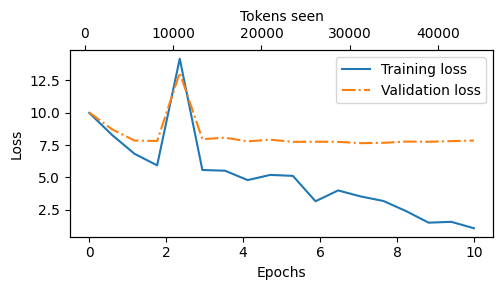

In [60]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax2 = ax1.twiny() #A
    ax2.plot(tokens_seen, train_losses, alpha=0) #B
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)


#根据上面的折线图我们可以看出这个模型过拟合了，原因是因为神经网络中有1.6亿个参数，但是训练集数据多样性过小，而且训练轮次过多，导致模型过于关注特征之间的细节，所以导致过拟合。

#上面我们已经完成了对模型的训练过程，接下来我们要讨论文本生成策略，也就是采样策略。

In [62]:
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know after.



"Oh, and his cheeks paled a little under their handsome sunburn's welcome was


In [64]:
# temperature scaling
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}
print(inverse_vocab)

{0: 'closer', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [72]:
#假设这是‘every effort moves you’的 logits
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)
probas = torch.softmax(next_token_logits, dim=0)
print(probas)
next_token_id = torch.argmax(probas).item()
print(next_token_id)
print(inverse_vocab[next_token_id])
#.item() 是将单一的张量元素转换为一个python的原生数值。例如int或float数据类型
#这是上面的那种方法选取最高概率作为下一个词的预测

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [68]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


#multinamial函数是pytorch中用于从给定的概率分布中进行抽样的函数
torch.multinomial(input, num_samples, replacement=False, *, out=None) → LongTensor
返回是抽样样本的索引
此外input函数可以归一化处理过或者不进行处理也行，该函数会自动帮助进行归一化
#bicount函数是 PyTorch 中用于统计整数张量中每个值的出现次数的函数。该函数返回一个 1D 张量，表示 input 张量中每个整数值的频率或加权和。输出张量的索引代表 input 中出现的整数值，其值代表该整数值在 input 中出现的次数或加权统计结果。

In [74]:
input = torch.tensor([0, 4, 5, 0, 10, 10, 2, 3])

# 统计每个整数的出现次数
result = torch.bincount(input)

print(result)
#索引值代表的就是整数的值

tensor([2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 2])


In [76]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


#我们可以看出概率高的单词自然就被抽样的次数就多，这种抽样的好处就在于不会固定的预测一个单词，其他低频的单词也会被抽到。增加了生成文本的随机性和多样性，降低模型对于高频模式的的依赖，使得模型处理新的场景时具有一定的泛化能力，使得语言的回答更具有一定的创造力。

# temperature scaling说白了就是将输出的logits张量除以一个大于0的数（temperature）,进一步控制分布和选择过程

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03]), tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
        2.9718e-38, 9.0133e-03, 2.8514e-22]), tensor([0.1546, 0.0750, 0.0429, 0.2421, 0.0869, 0.0454, 0.0430, 0.2203, 0.0898])]
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8])


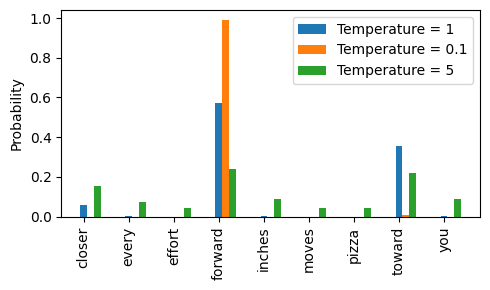

In [90]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)
#Temperatures greater than 1 result in more uniformly distributed token probabilities, and Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions. Let's illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:
temperatures = [1, 0.1, 5]             #A
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
print(scaled_probas)
x = torch.arange(len(vocab))
print(x)
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
                   bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()

#当 temperature 设置为非常小的值（如 0.1）时，生成的分布会更加尖锐，因此multinomial函数几乎总是选择最可能的 token（这里是 ‘forward’），其行为接近 argmax 函数。相反，当 temperature 设置为 5 时，生成的分布更接近均匀分布，其他 token 被选中的频率更高。这种情况下，生成的文本多样性增加，但也更可能出现无意义的内容。

In [88]:
for i ,probas in enumerate(scaled_probas):
    print(f"the temperature is {temperatures[i]}")
    print_sampled_tokens(probas)

the temperature is 1
71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you
the temperature is 0.1
0 x closer
0 x every
0 x effort
992 x forward
0 x inches
0 x moves
0 x pizza
8 x toward
the temperature is 5
153 x closer
68 x every
55 x effort
223 x forward
102 x inches
50 x moves
43 x pizza
218 x toward
88 x you


#我们可以发现再增加tmperature后，明显句子的生成的多样性和创造性增强，但是也会生成例如"every effort moves you pizza"这种比较离谱的单词，所以我们不需要概率较小的单词进行生成，而是主要随机取样前几个概率较高的单词就行了。所以我们在此引入top-k采样，例如我们将前k个概率值进行保留，然后将其他概率进行mask成-inf

#.topk函数函数是 PyTorch 中用于获取张量中前 k 个最大（或最小）值及其索引的函数。返回值如下：
values, indices = torch.topk(tensor, k)

In [92]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [96]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],   #A
    input=torch.tensor(float('-inf')),              #B
    other=next_token_logits                         #C
)
print(new_logits)

#A 识别出小于 top 3 最小值的 logits
#B 将这些较小的 logits 赋值为负无穷大
#C 保留所有其他 token 的原始 logits
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])
tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


In [112]:
# Listing 5.4 A modified text generation function with more diversity
def generate(model, idx, max_new_tokens, context_size,
             temperature=1.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):                             #A
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:                                   #B
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:                                       #C
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:                                                       #D
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:                                      #E
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx


#A For循环与之前相同：获取logits，仅关注最后的时间步
#B 在新步骤中，通过top-k采样过滤logits
#C 在新步骤中应用temperature scaling
#D 在未使用temperature scaling时，执行贪婪的下一个token选择
#E 如果遇到序列结束token且指定了eos_id，则提前停止生成

In [114]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you how I, in talking amate skill, he painted can to see it


根据你的观察，你能想到哪些应用场景适合较低的 temperature 和 top-k 设置吗？反之，哪些应用场景适合较高的 temperature 和 top-k 设置？

低 temperature 和低 top-k：适合生成确定性输出，应用于对准确性、连贯性要求高的任务。
高 temperature 和高 top-k：适合生成多样化的、富有创造性的内容，应用于需要探索或创新的场景。
中等设置：适合平衡输出，适用于聊天机器人、自动内容生成等需要既连贯又具有一定变化的场景。

generate 函数有哪些不同的设置组合可以强制生成确定性行为，即禁用随机采样，使其输出始终一致，类似于 generate_simple 函数？

In [116]:
token_ids2 = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=0
)
token_ids3 = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=None,
    temperature=0
)
print("Output text:\n", token_ids_to_text(token_ids2, tokenizer))
print("Output text:\n", token_ids_to_text(token_ids3, tokenizer))

Output text:
 Every effort moves you know after.



"Oh, and his cheeks paled
Output text:
 Every effort moves you know after.



"Oh, and his cheeks paled


In [118]:
#保存模型
#torch.save(model.state_dict(), "model.pth")
#保存优化器梯度下降历史
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

#如果保存完model后，下一次仅仅使用模型推理不要进一步训练和优化那么就只用保存model和load model就行，但是如果还想在以后的实验过程中继续训练模型那么我们需要将优化器一起进行save，因为保存优化器会保存使用历史数据动态调整每个模型参数的学习率。没有这些信息时，优化器会重置，模型可能无法有效学习，甚至无法正确收敛，进而失去生成连贯文本的能力。

In [ ]:
#加载模型,一般进行推理的时候我们并不希望丢弃某些神经元所以在这里我们使用.eval
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("model.pth"))
# model.eval()

#加载模型和优化器
# checkpoint = torch.load("model_and_optimizer.pth")
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(checkpoint["model_state_dict"])
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
# optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
# model.train()

In [122]:
#尝试从openAI中加载预训练权重
!pip install tensorflow>=2.15.0 tqdm>=4.66

In [125]:
import urllib.request
url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x22ca8832bd0>)

In [127]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████████████████████████████████████████████████████████████████████| 77.0/77.0 [00:00<?, ?iB/s]
encoder.json: 100%|██████████████████████████████████████████████████████████████| 1.04M/1.04M [00:00<00:00, 1.23MiB/s]
hparams.json: 100%|████████████████████████████████████████████████████████████████| 90.0/90.0 [00:00<00:00, 9.77kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████████████████████████████████████████| 498M/498M [02:10<00:00, 3.82MiB/s]
model.ckpt.index: 100%|██████████████████████████████████████████████████████████| 5.21k/5.21k [00:00<00:00, 2.73MiB/s]
model.ckpt.meta: 100%|██████████████████████████████████████████████████████████████| 471k/471k [00:00<00:00, 853kiB/s]
vocab.bpe: 100%|████████████████████████████████████████████████████████████████████| 456k/456k [00:00<00:00, 636kiB/s]


In [129]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [131]:
#我们尝试将GPT2中的配置设置为我们设计的GPTModel
# First, we create a dictionary that lists the differences between the different GPT model sizes, as explained in Figure 5.17:
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
# Suppose we are interested in loading the smallest model, "gpt2-small (124M)". We can use the corresponding settings from the model_configs table able to update our full-length GPT_CONFIG_124M we defined and used earlier throughout the chapter as follows:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
#OpenAI 在多头注意力模块的线性层中使用了偏置向量，以实现查询（query）、键（key）和值（value）矩阵的计算。偏置向量在现代 LLM 中已不再常用，因为它们对提升模型性能没有帮助，因而不再必要。
NEW_CONFIG.update({"qkv_bias": True})
# We can now use the updated NEW_CONFIG dictionary to initialize a new GPTModel instance:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

为此，我们首先来定义一个简单的assign工具函数，用于检查两个张量或数组（左侧和右侧）的维度或形状是否一致，并将右侧张量作为可训练的 PyTorch 参数返回：

In [133]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [135]:
#将params字典中的权重加载到我们的模型当中
# Listing 5.5 Loading OpenAI weights into our GPT model code
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])               #A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    for b in range(len(params["blocks"])):                                       #B
        q_w, k_w, v_w = np.split(                                                #C
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])                   #D


#A 将模型的位置嵌入和token 嵌入的权重设置为 params 中指定的值
#B 遍历模型中的每个 Transformer 模块
#C 使用 np.split 函数将注意力和偏置权重分为三等份，分别用于查询、键和值组件
#D OpenAI 的原始 GPT-2 模型在输出层中复用了 token 嵌入的权重，以减少参数总量，这一概念称为权重共享

In [139]:
#其实我们可以用下面简单的方法将parameter加载到我们的模型中,上面那种只是开发过程去检测是否有维度不匹配的情况
load_weights_into_gpt(gpt, params)
gpt.to(device)
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the
